In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import os

import numpy as np

from PIL import Image
import glob
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset 

### Data Loader
#### - Loading Data (ImageNet, cifar-10, etc not MNIST)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Set Data path
datapath = './data'
os.makedirs(datapath, exist_ok=True)

# Pre-process
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Laod MNIST
train_dataset = datasets.MNIST(datapath, train=True, download=True, transform=trans)


img.shape: torch.Size([60000, 28, 28])
label.shape: torch.Size([60000])
Unsqueezed img.shape: torch.Size([60000, 1, 28, 28])


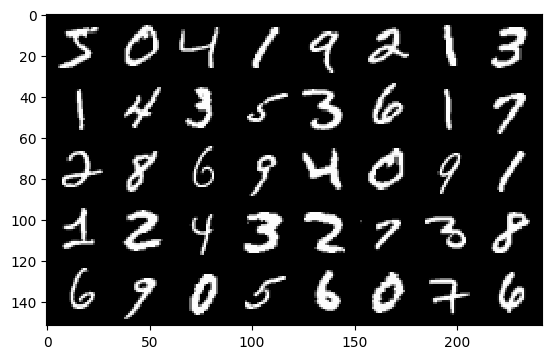

In [4]:
img, label = train_dataset.data, train_dataset.targets
print('img.shape:', img.shape)
print('label.shape:', label.shape)

# Make it to 4D Tensor
# 기존 : (#Batch) x (height) x (width) -> (#Batch) x (#channel) x (height) x(width)
if len(img.shape) == 3:
    img = img.unsqueeze(1)
print('Unsqueezed img.shape:', img.shape)

# Visualize
img_grid = utils.make_grid(img[:40], ncol=8, padding=2)
def show(img):
    img = img.numpy() # Tensor -> numpy array
    img = img.transpose([1,2,0]) # C x H x W -> H x W x C
    plt.imshow(img, interpolation='nearest')
show(img_grid)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(len(train_loader))

938


In [6]:
# set parameters
params = {
    'num_classes':10,
    'nz':100,
    'input_size':(1,28,28)
}

In [7]:
class Generator(nn.Module):
    
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes']
        self.nz = params['nz'] # 노이즈 수
        self.input_size = params['input_size'] # (1,28,28
        
        # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)
        
        # Generator
        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        # noise와 label의 결합
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x
    
# check
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [8]:
class Discriminator(nn.Module):
    
     def __init__(self, params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
     def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)
        x = self.dis(dis_input)
        return x
    
# check
x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


In [9]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [10]:
# 손실 함수
loss_func = nn.BCELoss() 

from torch import optim

lr = 1e-6
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2)) # Discrminator
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2)) # Generator

# 학습 파라미터
nz = params['nz'] # Noise vector initialize
num_epochs = 20000

loss_history={'gen':[],
              'dis':[]}

In [11]:
# Train
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_loader:
        ba_si = xb.shape[0]
        
        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label
        
        # Genetator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

         # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()
        
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = loss_func(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 0.840842, D_Loss: 0.599896, time: 0.29 min
Epoch: 2, G_Loss: 0.808238, D_Loss: 0.486603, time: 0.63 min
Epoch: 3, G_Loss: 1.959243, D_Loss: 0.685462, time: 0.92 min
Epoch: 4, G_Loss: 1.111197, D_Loss: 0.522127, time: 1.22 min
Epoch: 5, G_Loss: 1.312697, D_Loss: 0.486012, time: 1.52 min
Epoch: 6, G_Loss: 1.514878, D_Loss: 0.435516, time: 1.82 min
Epoch: 7, G_Loss: 0.897368, D_Loss: 0.549538, time: 2.12 min
Epoch: 8, G_Loss: 1.130640, D_Loss: 0.460948, time: 2.41 min
Epoch: 9, G_Loss: 1.619465, D_Loss: 0.427811, time: 2.71 min
Epoch: 10, G_Loss: 1.750831, D_Loss: 0.415778, time: 3.00 min
Epoch: 11, G_Loss: 2.176405, D_Loss: 0.484787, time: 3.30 min
Epoch: 12, G_Loss: 1.249808, D_Loss: 0.390906, time: 3.59 min
Epoch: 13, G_Loss: 1.497147, D_Loss: 0.474637, time: 3.89 min
Epoch: 14, G_Loss: 1.614125, D_Loss: 0.383526, time: 4.19 min
Epoch: 15, G_Loss: 1.679283, D_Loss: 0.373707, time: 4.48 min
Epoch: 17, G_Loss: 1.306965, D_Loss: 0.417485, time: 4.78 min
Epoch: 18, G_Loss

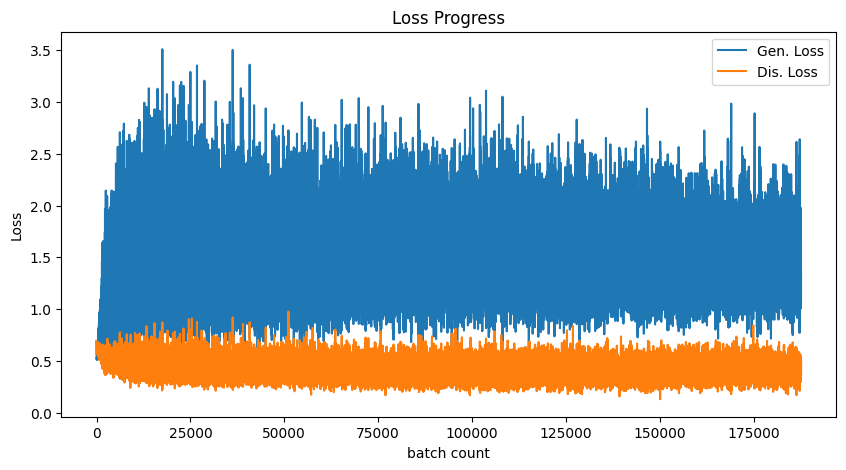

In [12]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

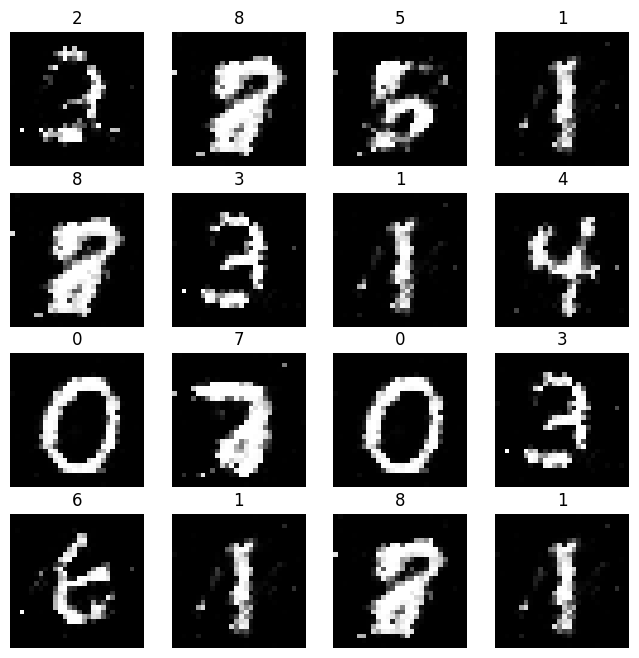

In [15]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(8,8))
    cols, rows = 4, 4 # row와 col 갯수
    for i in range(rows * cols):
        fixed_noise = torch.randn(16, 100, device=device)
        label = torch.randint(0,9,(16,), device=device)
        img_fake = model_gen(fixed_noise, label).detach().cpu()
        fig.add_subplot(rows, cols, i+1)
        plt.title(label[i].item())
        plt.axis('off')
        plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()

In [ ]:
'''
0 gyaetongdo
1 pyeongmyundo
2 goosungdo
3 gigibaechido
4 Legends
5 layout
6 cable_wiring_diagram
7 Seonbunjang
8 poseoldo
9 sangsaedo
10 gaehwangdo
11 wiichido
12 domyunmokcha
13 gujomooldo
14 ganji
15 jickseondo
'''